In [ ]:
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
import itertools
import matplotlib.pyplot as plt
from copy import copy
from scipy.stats import entropy, rayleigh


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
@dataclass
class QPSK_symbols:
    symbols = np.asarray([0, 1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j])
    amplitude = np.sqrt(2)


@dataclass
class QAM_symbols:
    symbols = np.asarray(
                          [3 + 3j,
                          3 + 1j,
                          3 - 3j,
                          3 - 1j,
                          1 + 3j,
                          1 + 1j,
                          1 - 3j,
                          1 - 1j,
                          -3 + 3j,
                          -3 + 1j,
                          -3 - 3j,
                          -3 - 1j,
                          -1 + 3j,
                          -1 + 1j,
                          -1 - 3j,
                          -1 - 1j])
    amplitude = np.sqrt(18)


class OFDMDataset(Dataset):
  def __init__(self, n_of_data: int, nfft: int = 16, modulation_type:str ='qpsk', n_zero: int = 0):
    super().__init__()

    self.nfft = nfft
    self.n_of_data = n_of_data
    self.modulation_type = modulation_type
    self.symbols = {'qpsk': QPSK_symbols, 'QAM': QAM_symbols}

    self.max_aplitude = self.symbols[modulation_type].amplitude
    self.symbols = self.symbols[modulation_type].symbols

    index_symbols = np.arange(1, len(self.symbols))
    self.generated_sequences_ids = np.random.choice(index_symbols, size=(n_of_data, nfft))

    self.complex_symbols = self.symbols[self.generated_sequences_ids]

    ifft_symbols = np.fft.ifft(np.asarray(self.complex_symbols))

    self.abs_values = np.abs(ifft_symbols)

    self.generated_sequences_ids = torch.tensor(self.generated_sequences_ids)

    self.abs_values = torch.tensor(self.abs_values, dtype=torch.float32)
    self.abs_values /= self.max_aplitude

    self.generated_sequences_ids_one_hot = F.one_hot(self.generated_sequences_ids, num_classes=len(self.symbols)).type(torch.float32)
    self.generated_sequences_ids = self.generated_sequences_ids.type(torch.float32)


  def __len__(self):
      return self.n_of_data

  def __getitem__(self, idx):
    return self.generated_sequences_ids[idx], self.generated_sequences_ids_one_hot[idx], self.abs_values[idx]

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_units: int, nfft: int, dropout: float = 0.4):
        super(Encoder, self).__init__()

        self.single_part = nn.ModuleList(nn.Sequential(*[nn.Linear(1, hidden_units),
                                          nn.GELU(),
                                          nn.Dropout(dropout),
                                          nn.Linear(hidden_units, hidden_units//nfft),
                                          nn.GELU(),
                                          nn.Dropout(dropout),]) for _ in range(nfft))

        self.shared_part = nn.Sequential(*[nn.Linear(hidden_units, nfft)])

    
    def forward(self, x: list):
        B, L = x.shape
        x = x.view(B, L, 1).permute(1,0,2)
        outs = [branch(input) for branch, input in zip(self.single_part, x)]
        output_branch = torch.cat(outs, dim=1)
        out = F.sigmoid(self.shared_part(output_branch))
        return out

class Decoder(nn.Module):
    def __init__(self,hidden_units: int, nfft: int, n_vocabulary: int, dropout: float = 0.4):
        super().__init__()
        self.nfft = nfft
        self.n_vocabulary = n_vocabulary
        self.hidden_units = hidden_units

        self.shared_part = nn.Sequential(*[nn.Linear(nfft, hidden_units),
                                           nn.GELU(),
                                           nn.Dropout(dropout)])
        self.single_part = nn.ModuleList(nn.Sequential(*[nn.Linear(hidden_units//nfft, hidden_units),
                                          nn.GELU(),
                                          nn.Dropout(dropout),
                                          nn.Linear(hidden_units, n_vocabulary),
                                          nn.Softmax()]) for _ in range(nfft))

    def forward(self, x):
        N,L  = x.shape
        x = self.shared_part(x)
        x = x.view(N, self.nfft, self.hidden_units//self.nfft).permute(1,0,2)

        outs = [single_branch(input) for single_branch, input in zip(self.single_part, x)]
        
        return outs

class Encoder_Decoder(nn.Module):
    def __init__(self, nfft: int, hidden_dim: int, n_output_vocabulary: int):
        super(Encoder_Decoder, self).__init__()
        self.encoder = Encoder(hidden_dim, nfft)
        self.decoder = Decoder(hidden_dim, nfft, n_output_vocabulary)

    
    def forward(self, x: list) -> list:
        x = self.encoder(x)
        return self.decoder(x)

In [ ]:
def loss_functions(prediction, predition_good_vector, X_one_hot, losses_good_vector, losses_reconstruction):

  n_of_samples = len(prediction)

  loss_reconstruction = 0
  loss_good_vec = 0

  for ids in range(n_of_samples):
    loss_reconstruction += losses_reconstruction[ids](X_one_hot[:,ids], prediction[ids])
    loss_good_vec += losses_good_vector[ids](X_one_hot[:,ids], predition_good_vector[ids])

  
  loss_reconstruction /= n_of_samples
  loss_good_vec /= n_of_samples

  return loss_reconstruction + loss_good_vec

def accuracy_function(pred_list, X_list):
    X_list = X_list.permute(1,0,2)
    accs = torch.tensor([(pred.argmax(1) == X.argmax(1).to(device)).type(torch.float).sum().item() for pred, X in zip(pred_list, X_list)])
    return torch.mean(accs)

In [ ]:
batch_size = 256
epochs = 50
lr = 0.00001
nfft = 16

In [ ]:
data_train = OFDMDataset(50000, nfft=nfft)
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)

data_test = OFDMDataset(20000,nfft=nfft)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=True)


In [ ]:
def train_loop(dataloader, model, losses_good_vector, losses_reconstruction, optimizer):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss = 0.0
  train_accuracy = 0.0

  for batch, (X, X_one_hot, abs_val) in enumerate(dataloader): 
    # Compute prediction and loss
    pred = model(X.to(device))
    predition_good_vector = model.decoder(abs_val.to(device))
    X_one_hot = X_one_hot.to(device)

    loss = loss_functions(pred, predition_good_vector, X_one_hot, losses_good_vector, losses_reconstruction)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    train_accuracy += accuracy_function(predition_good_vector, X_one_hot)


    if batch % 50 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      print()
  
  train_loss /= num_batches
  train_accuracy /= size

  return train_loss, train_accuracy


def test_loop(dataloader, model, losses_good_vector, losses_reconstruction):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, test_accuracy = 0, 0

  with torch.no_grad():
    for X, X_one_hot, abs_val in dataloader:
      pred = model(X.to(device))
      X_one_hot = X_one_hot.to(device)
      predition_good_vector = model.decoder(abs_val.to(device))
      test_loss += loss_functions(pred, predition_good_vector, X_one_hot, losses_good_vector, losses_reconstruction)
      
      test_accuracy +=  accuracy_function(predition_good_vector, X_one_hot)

  test_loss /= num_batches
  test_accuracy /= size
  print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss, test_accuracy

In [ ]:
model = Encoder_Decoder(nfft, hidden_dim=64, n_output_vocabulary=5).to(device)

In [ ]:
losses_good_vector = [nn.CrossEntropyLoss() for _ in range(nfft)]
losses_reconstruction = [nn.CrossEntropyLoss() for _ in range(nfft)]

In [ ]:
####LEARNING WITH_FIRST_TRANSFORMATION_####
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

#training process
for t in range(epochs):
  print("-------Training model--------")
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_accuracy = train_loop(dataloader_train, 
                                          model, 
                                          losses_good_vector, 
                                          losses_reconstruction,
                                          optimizer)
  
  test_loss, test_accuracy = test_loop(dataloader_train, 
                              model, 
                              losses_good_vector, 
                              losses_reconstruction)
  
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)


print("Done!")



-------Training model--------
Epoch 1
-------------------------------
loss: 3.410280  [    0/50000]

loss: 3.410080  [12800/50000]

loss: 3.408356  [25600/50000]

loss: 3.408143  [38400/50000]

Test Error: 
 Accuracy: 22.8%, Avg loss: 3.407341 

-------Training model--------
Epoch 2
-------------------------------
loss: 3.407959  [    0/50000]

loss: 3.407780  [12800/50000]

loss: 3.406902  [25600/50000]

loss: 3.404020  [38400/50000]

Test Error: 
 Accuracy: 23.8%, Avg loss: 3.404329 

-------Training model--------
Epoch 3
-------------------------------
loss: 3.404125  [    0/50000]

loss: 3.402883  [12800/50000]

loss: 3.404878  [25600/50000]

loss: 3.401833  [38400/50000]

Test Error: 
 Accuracy: 24.3%, Avg loss: 3.401399 

-------Training model--------
Epoch 4
-------------------------------
loss: 3.401892  [    0/50000]

loss: 3.400126  [12800/50000]

loss: 3.398754  [25600/50000]

loss: 3.400480  [38400/50000]

Test Error: 
 Accuracy: 24.7%, Avg loss: 3.398510 

-------Training 

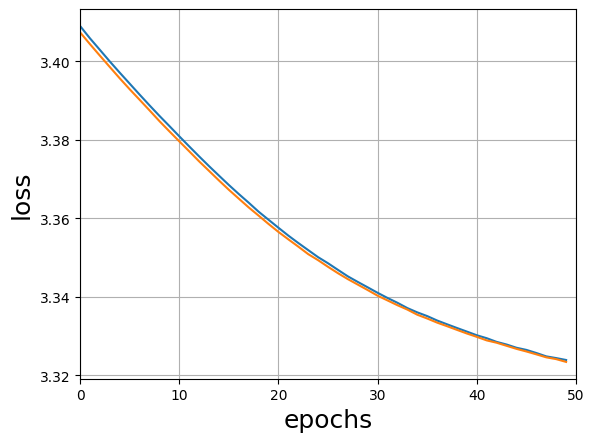

<Figure size 640x480 with 0 Axes>

In [192]:
plt.figure()
plt.plot(train_losses, label='train')
plt.plot([x.item() for x in test_losses], label='test')
plt.grid()
plt.xlabel('epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlim([0,50])
plt.show()
plt.savefig('loss.png')

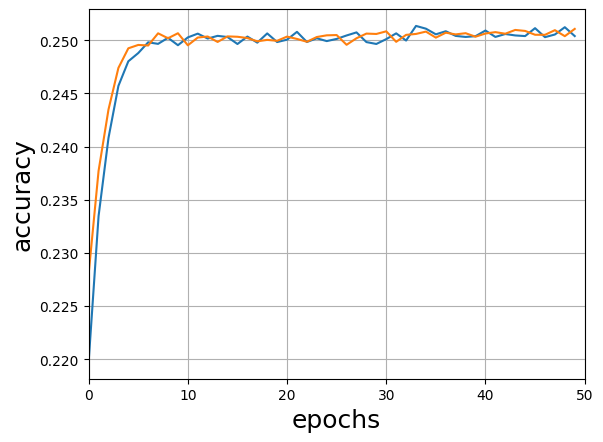

<Figure size 640x480 with 0 Axes>

In [191]:
plt.figure()
plt.plot(train_accuracies)
plt.plot([x.item() for x in test_accuracies])
plt.grid()
plt.xlabel('epochs', fontsize=18)
plt.ylabel('accuracy', fontsize=18)
plt.xlim([0,50])
plt.show()
plt.savefig('accuracy.png')